In [31]:
# License: BSD
# Author: Sasank Chilamkurthy+Zhang Liangjun
#verson 1.0
#class 2classes
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import scipy.io as scio
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import os
import torch.utils.data as data
import random
import shutil
import glob
import csv
import math
import pandas
import cv2
from matplotlib import pyplot as plt
from skimage import transform



In [32]:
#input:mat file
#output: tensor
def mat_read(filepath):
    dataFile = filepath
    data = scio.loadmat(dataFile)
    #读取mat里的depth数据
    depth = data['depth']
    #归一化
    depth=depth*300
    depth=depth.astype(np.int)
    depth=depth.astype(np.float)
    #depth = transform.resize(depth,(240,320))
    depth_scale=depth[depth>0]
    avrg=np.mean(depth_scale)
    var=np.std(depth_scale)
    index=depth==0
    depth[index]=avrg
    depth_scale=(depth-avrg)/var
    depth=np.array(depth_scale)

    depth=np.expand_dims(depth,0)
    return depth
#把数据文件分成训练集和测试集
def generate_datasets(data_dir, dst_dir, train_ratio=0.7):
    train_dir = os.path.join(dst_dir,'train')
    val_dir = os.path.join(dst_dir,'val')
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)
        os.mkdir(train_dir)
        os.mkdir(val_dir)
    for root, dirnames, _ in os.walk(data_dir):
        for dirname in dirnames:
            #因为需要的数据在更下一层的depth文件里，所以加了几句，后边带俩#的为改过的部分，
            #如果不需要做depth改过来就行了
            depth_dirname=os.path.join(dirname,'depth')##
            subdirname_train = os.path.join(train_dir, dirname)
            subdirname_val = os.path.join(val_dir, dirname)
            if not os.path.exists(subdirname_train):
                os.mkdir(subdirname_train)
            if not os.path.exists(subdirname_val):
                os.mkdir(subdirname_val)                                        
            dname = os.path.join(root, depth_dirname)##depth_dirname原本是dirname
            #dname = os.path.join(root, dirname)
            names = glob.glob(dname+r'/*.mat')  
            random.shuffle(names)
            names_len = len(names)
            train_names = names[:int(names_len*train_ratio)]
            val_names = names[int(names_len*train_ratio)+1:]
            for f in train_names:
                fname = os.path.split(f)[-1]
                train_dname = os.path.join(subdirname_train, fname)
                shutil.copyfile(f, train_dname)
            for f in val_names:
                fname = os.path.split(f)[-1]
                val_dname = os.path.join(subdirname_val, fname)
                shutil.copyfile(f, val_dname)
            print ('copy {} done'.format(dname))
        
data_dir = '/home/sjtu/gcj/data/view25'
dst_dir = '/home/sjtu/gcj/data/depth_data/depth_26class'
#generate_datasets(data_dir, dst_dir)
        

In [33]:
EXTENSIONS = ['.mat']
def is_mat_file(filename):
    return any(filename.endswith(extension) for extension in EXTENSIONS)

#类名
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    classes.sort()
    class_to_idx = {classes[i]:i for i in range(len(classes))}
    return classes,class_to_idx

#input: dir+train(or val)+class
#output: 数据文件的集合
def make_dataset(dir,phase,class_to_idx):
    datas = []
    labels = []
    dir = os.path.join(dir,phase)
    for target in os.listdir(dir):
        d = os.path.join(dir,target)
        if not os.path.isdir(d):
            continue
        
        for root, _, fnames in sorted(os.walk(d)):
            for fname in fnames:
                if is_mat_file(fname):
                    path = os.path.join(root,fname)
                    #depth=mat_read(path)
                    item = (path,class_to_idx[target])
                    datas.append(item)
                    #datas.append(depth)
                    #labels.append(class_to_idx[target])
    return datas



In [34]:
class ViewpointDataset(data.Dataset):
    def __init__(self, root, transform = None, phase = None):
        dir = os.path.join(root, phase)
        classes, class_to_idx = find_classes(dir)
        datas= make_dataset(root,phase, class_to_idx)
        if len(datas) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported extensions are: " + ",".join(EXTENSIONS)))
        self.root = root
        self.phase = phase
        self.classes = classes
        #todo
        self.width = 480
        self.height = 640
        self.suffix = '.mat'
        self.transform = transform
        self.datas=datas
        
    #深度矩阵转成tensor  
    def __getitem__(self, idx):
        mat_path, label = self.datas[idx]
        #preprocess
        depth= mat_read(mat_path)
        #depth,label=self.datas[idx]
        #depth=self.datas[idx]
        #label=self.labels[idx]


        #create tensor from numpy.ndarray
        depth=torch.from_numpy(depth)

        depth_tensor=depth.type(torch.FloatTensor)
        if self.transform:
            toPIL=transforms.ToPILImage()
            toTensor=transforms.ToTensor()
            depth_tensor = toTensor(self.transform(toPIL(depth_tensor)))
        return depth_tensor, label
    
    def __len__(self):
        return len(self.datas)

    #设置梯度更新方式
    #增大学习率是个好办法
def optim_scheduler_ft(model, epoch, init_lr=0.0005, lr_decay_epoch=7):
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))
    #lr = init_lr
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer

In [35]:
#建立数据集
#transform=transforms.Compose([transforms.RandomSizedCrop(1)])
#transform=transforms.RandomCrop([300,300])
#dsets = {x: ViewpointDataset(dst_dir,transform=transform,phase=x) for x in ['train', 'val']}
dsets = {x: ViewpointDataset(dst_dir,phase=x) for x in ['train', 'val']}
dset_loaders = {x:torch.utils.data.DataLoader(dsets[x],batch_size=24,shuffle=True, num_workers=8) for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['val'].classes
print(dset_sizes)
print(len(dset_classes))
use_gpu = torch.cuda.is_available()

{'train': 76436, 'val': 32733}
26


In [40]:
#训练所用网络模型：
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(11,11),stride=(4,4),padding=(2,2)) # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv2 = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        #self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv5 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #480*640:5120  300*300:1024
        #self.fc1   = nn.Linear(5120, 120) # an affine operation: y = Wx + b
        self.fc4   = nn.Linear(512, 512) 
        self.fc1   = nn.Linear(512, 256) 
        #self.fc2   = nn.Linear(120, 120) 
        #self.fc2   = nn.Linear(120,84)
        #self.fc2   = nn.Linear(1024, 120)
        self.fc3   = nn.Linear(256, 26)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 4) # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 4) # If the size is a square you can only specify a single number
        #x = F.max_pool2d(F.relu(self.conv3(x)), 3) 
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(F.relu(self.conv5(x)), 4) 
        x = x.view(-1, self.num_flat_features(x))
        #'''
        x = F.dropout(x,p=0.7)
        x=F.relu(self.fc4(x))
        x=  F.dropout(x,p=0.6)
        x = F.relu(self.fc1(x))
        x=  F.dropout(x,p=0.4)
        #x=  F.dropout(x,p=0.5)
        #x = F.relu(self.fc2(x))
        #x=  F.dropout(x,p=0.4)
        #x = F.relu(self.fc3(x))
        x=  F.dropout(x,p=0.5)
        x = self.fc3(x)
        #'''
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
model = Net().cuda()
print(model)
'''
a=mat_read('/home/sjtu/gcj/data/depth_data/depth_2class/train/off_32_0_180/95_depth.mat')
depth=torch.from_numpy(a)
a=depth.type(torch.FloatTensor)
c=torch.FloatTensor(1,1,480,640)#需要写成3dtensor 1代表batch
c[0]=a
b=Variable(c.cuda())
print(type(b))
outputs = model(b)
print outputs
#'''

Net (
  (conv1): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc4): Linear (512 -> 512)
  (fc1): Linear (512 -> 256)
  (fc3): Linear (256 -> 26)
)


"\na=mat_read('/home/sjtu/gcj/data/depth_data/depth_2class/train/off_32_0_180/95_depth.mat')\ndepth=torch.from_numpy(a)\na=depth.type(torch.FloatTensor)\nc=torch.FloatTensor(1,1,480,640)#\xe9\x9c\x80\xe8\xa6\x81\xe5\x86\x99\xe6\x88\x903dtensor 1\xe4\xbb\xa3\xe8\xa1\xa8batch\nc[0]=a\nb=Variable(c.cuda())\nprint(type(b))\noutputs = model(b)\nprint outputs\n#"

In [41]:
##定义模型如何训练
def train_model(model, criterion, optim_scheduler, num_epochs=25):
    since = time.time()
        
    best_model = model
    best_acc = 0.0
    count=0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = optim_scheduler(model, epoch)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data
                #print(type(inputs))
                # wrap them in Variable
                if use_gpu and phase=='train':
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                elif use_gpu and phase=='val':
                    inputs, labels = Variable(inputs.cuda(),volatile=True), Variable(labels.cuda(),volatile=True)
                    #inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                #print(type(inputs))
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds== labels.data)
                #print(running_loss)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = float(running_corrects) / float(dset_sizes[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
        model_name='./model/model_26class_'+str(count)+'.pth'
        torch.save(best_model,model_name)
        count=count+1

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    torch.save(best_model, './model/model_26class.pth')
    print('done')
    return best_model

In [42]:
#def real_data(filepath):
def test(csv_path):
    with open(csv_path) as f:
        l=[]
        lines=csv.reader(f)
        for line in lines:
            l.append(line)
    l.remove(l[0])
    l=np.array(l)
    depth=l[:,1:]
    #print np.shape(depth)

    depth=depth.astype(np.float)
    #depth = transform.resize(depth,(240,320))
    #depth[:120,:]=0
    #depth[330:,:]=0
    #depth[:,500:]=0
    #depth[:,0:0]=0
    
    depth_scale=depth[depth>0]
    avrg=np.mean(depth_scale)
    var=np.std(depth_scale)
    index=depth==0
    depth[index]=avrg
    depth_scale=(depth-avrg)/var
    
    '''#depth_scale=depth_scale[100:400,200:500]
    depth_scale = depth_scale*100
    depth_scale=depth_scale.astype(np.int)
    depth=depth.astype(np.float)/100
    #depth_scale=cv2.blur(depth_scale,(3,5))
    #depth_scale=cv2.GaussianBlur(depth_scale,(5,5),1.5)
    #depth_scale=cv2.medianBlur(depth_scale,5)
    '''
    #depth_scale = cv2.bilateralFilter(depth_scale,9,75,75)
    depth3=np.expand_dims(depth_scale,0)
    depth3=np.expand_dims(depth3,0)
    #create tensor from numpy.ndarray
    depth=torch.from_numpy(depth3)
    depth=depth.type(torch.FloatTensor)
    return depth,depth_scale

def test_model(modelname,dir_name):
    for root, dirnames, _ in os.walk(dir_name):
        if len(dirnames)!=0:
            count=0
            acc=0
            length = 0
            for dirname in dirnames:
                this_acc = 0
                dname = os.path.join(root, dirname)
                names=glob.glob(dname+r'/*.csv')
                this_length  = len(names)
                #model=torch.load("./model_2class.pth")
                model=torch.load(modelname)
                model.cuda()
                length=len(names)+length
                for f in names:
                    fname = os.path.split(f)[-1]
                    csv_path = os.path.join(dname, fname)
                    inputs,depth_scale=test(csv_path)
                    label=dirname
                    inputs = Variable(inputs.cuda())
                    outputs = model(inputs)
                    #print outputs.data
                    _,preds = torch.max(outputs.data, 1)
                    preds = preds.cpu().numpy()
                    #print preds
                    #preds=[[12]]
                    #plt.imshow(preds)
                    #print dset_classes[preds[0][0]]
                    #plt.figure(count)
                    count=count+1
                    title_name=dset_classes[preds[0][0]].split('_')[2]+'_'+dset_classes[preds[0][0]].split('_')[3]
                    if label==title_name:
                        acc=acc+1
                        this_acc = this_acc+1
                    this_accuracy=float(this_acc)/float(this_length)
                    #print('{}`s Acc: {:.4f}'.format(dirname,this_accuracy))
            accuracy=float(acc)/float(length)
            print('{}`s Acc: {:.4f}'.format(modelname,accuracy))
            #plt.title(str(count)+' '+dset_classes[preds[0][0]])
            #plt.title(title_name)
            #plt.imshow(depth_scale)
    return accuracy,modelname

def visual_best_model(modelname,dir_name):
    for root, dirnames, _ in os.walk(dir_name):
        if len(dirnames)!=0:
            count=0
            acc=0
            length = 0
            for dirname in dirnames:
                this_acc = 0
                dname = os.path.join(root, dirname)
                names=glob.glob(dname+r'/*.csv')
                this_length  = len(names)
                #model=torch.load("./model_2class.pth")
                model=torch.load(modelname)
                model.cuda()
                length=len(names)+length
                for f in names:
                    fname = os.path.split(f)[-1]
                    csv_path = os.path.join(dname, fname)
                    inputs,depth_scale=test(csv_path)
                    label=dirname
                    inputs = Variable(inputs.cuda())
                    outputs = model(inputs)
                    #print outputs.data
                    _,preds = torch.max(outputs.data, 1)
                    preds = preds.cpu().numpy()
                    #print preds
                    #preds=[[12]]
                    #plt.imshow(preds)
                    #print dset_classes[preds[0][0]]
                    plt.figure(count)
                    count=count+1
                    title_name=dset_classes[preds[0][0]].split('_')[2]+'_'+dset_classes[preds[0][0]].split('_')[3]
                    if label==title_name:
                        acc=acc+1
                        this_acc = this_acc+1
                    plt.title(title_name)
                    plt.imshow(depth_scale)
                this_accuracy=float(this_acc)/float(this_length)
                print('{}`s Acc: {:.4f}'.format(dirname,this_accuracy))
            accuracy=float(acc)/float(length)
            print('{}`s Acc: {:.4f}'.format(modelname,accuracy))
            print('total:{}, wrong:{}'.format(length,length-acc))
            #plt.title(str(count)+' '+dset_classes[preds[0][0]])
    return accuracy,modelname


In [43]:
dname='./cropmap'
model_dir = './model'
train_num = 10
count = 0
for i in range(train_num):
#训练
#model=torch.load('./model/best2.pth')
#model.cuda()
    print("{} round".format(count+1))
    model = Net().cuda()
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.MSELoss()
    model = train_model(model,criterion, optim_scheduler_ft, num_epochs=10)
    modelname=glob.glob(model_dir+r'/model_26class_*.pth')
    modelname = sorted(modelname)
    bestacc=0
    best_model=None
    for model in modelname:
        acc,modeltemp=test_model(model,dname)
        if acc>=bestacc:
            best_model = modeltemp
            bestacc=acc
    print('Best_Acc: {:.4f}'.format(bestacc))
    print best_model
    bestmodel = torch.load(best_model)
    count = count +1
    model_name='./model/model_best_'+str(count)+'.pth'
    torch.save(bestmodel,model_name)
#print('All_Best_Acc: {:.4f}'.format(all_bestacc))
    #visual_best_model(best_model,dname)

1 round
Epoch 0/9
----------
LR is set to 0.0005
train Loss: 0.0109 Acc: 0.9184
val Loss: 0.0016 Acc: 0.9882
Epoch 1/9
----------
train Loss: 0.0017 Acc: 0.9898
val Loss: 0.0008 Acc: 0.9943
Epoch 2/9
----------
train Loss: 0.0013 Acc: 0.9935
val Loss: 0.0001 Acc: 0.9995
Epoch 3/9
----------
train Loss: 0.0013 Acc: 0.9942
val Loss: 0.0004 Acc: 0.9981
Epoch 4/9
----------
train Loss: 0.0012 Acc: 0.9952
val Loss: 0.0001 Acc: 0.9994
Epoch 5/9
----------
train Loss: 0.0015 Acc: 0.9947
val Loss: 0.0012 Acc: 0.9978
Epoch 6/9
----------
train Loss: 0.0019 Acc: 0.9943
val Loss: 0.0004 Acc: 0.9982
Epoch 7/9
----------
LR is set to 5e-05
train Loss: 0.0001 Acc: 0.9998
val Loss: 0.0001 Acc: 0.9993
Epoch 8/9
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0001 Acc: 0.9995
Epoch 9/9
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0001 Acc: 0.9998
Training complete in 49m 44s
Best val Acc: 0.999847
done
./model/model_26class_0.pth`s Acc: 0.6933
./model/model_26class_1.pth`s Acc: 0.7200
./

0_180`s Acc: 0.7692
60_0`s Acc: 0.9231
90_0`s Acc: 0.8000
0_0`s Acc: 0.9375
0_270`s Acc: 0.9167
0_90`s Acc: 1.0000
./model/model_4class_2.pth`s Acc: 0.8933
total:75, wrong:8


(0.8933333333333333, './model/model_4class_2.pth')

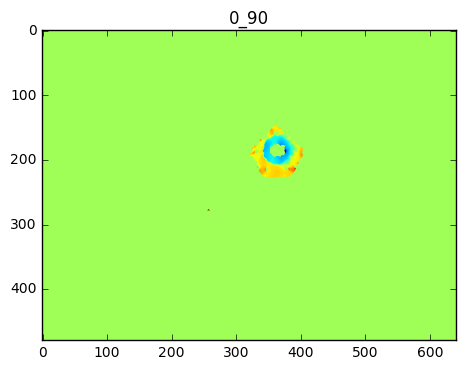

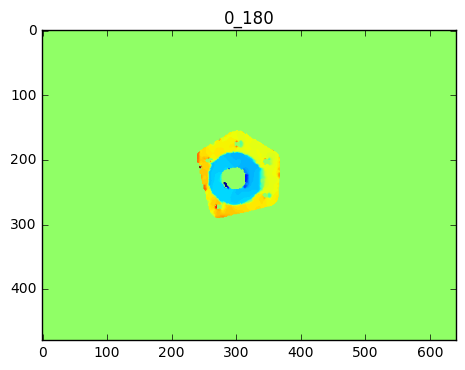

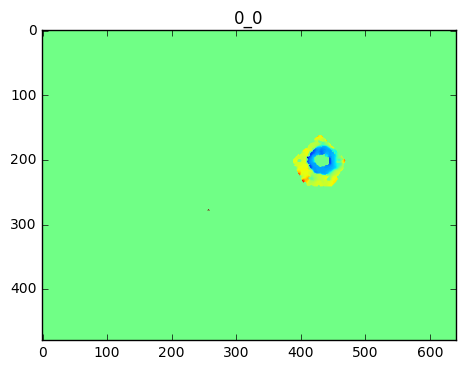

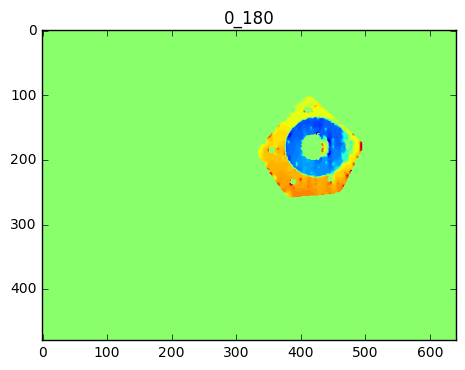

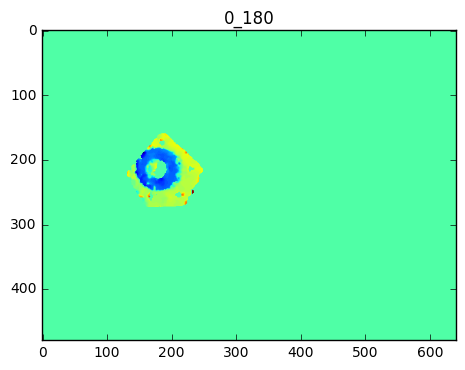

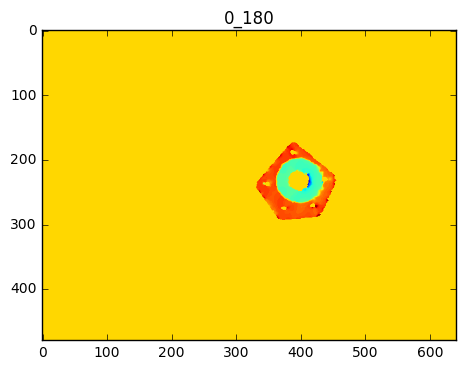

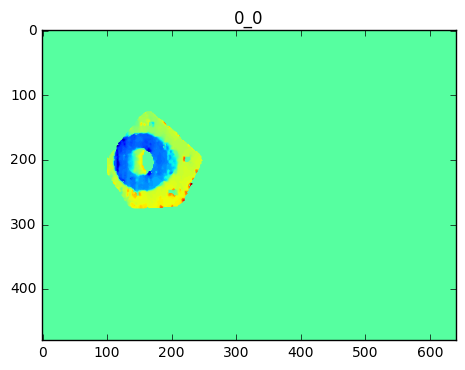

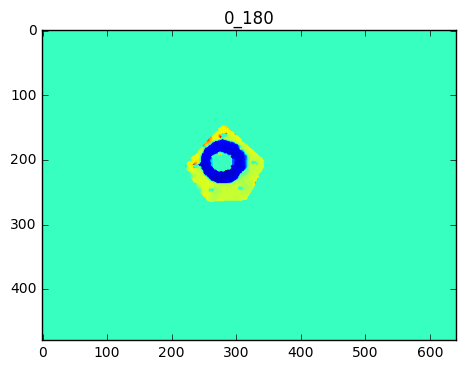

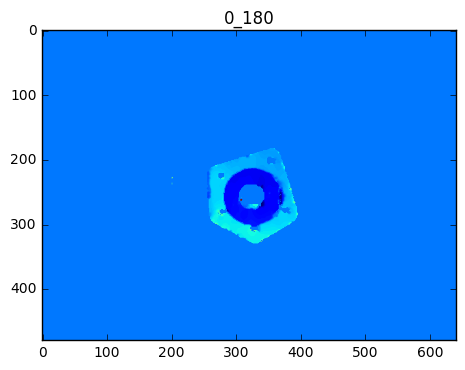

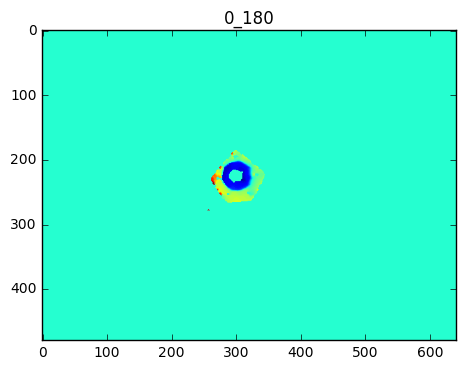

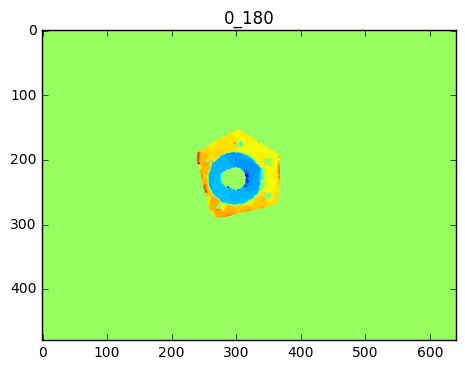

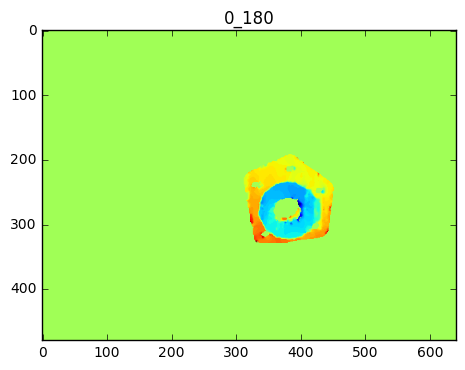

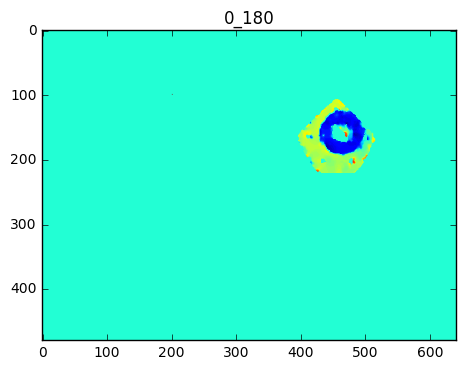

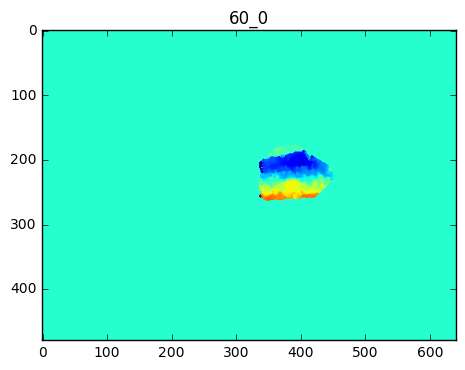

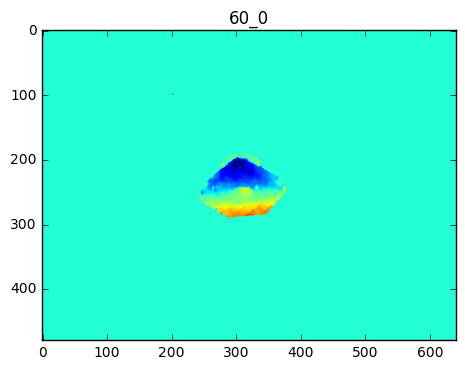

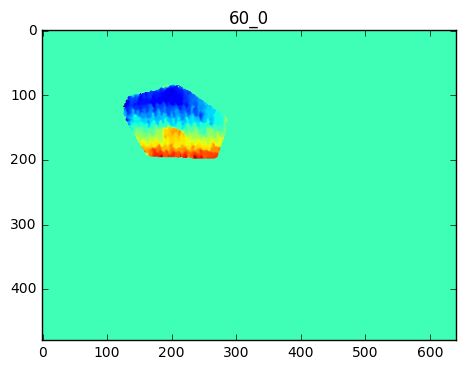

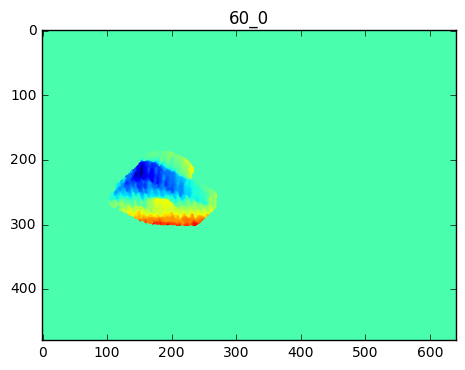

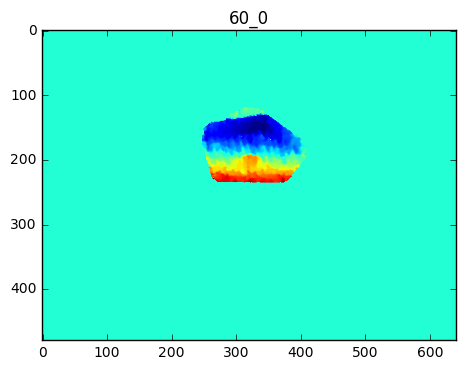

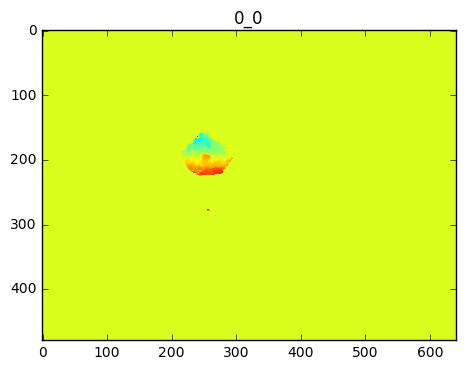

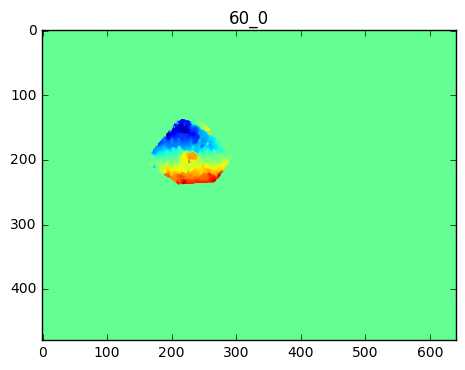

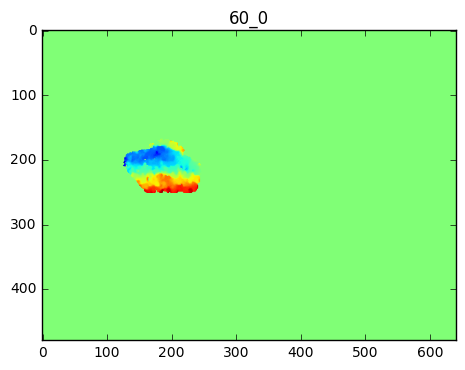

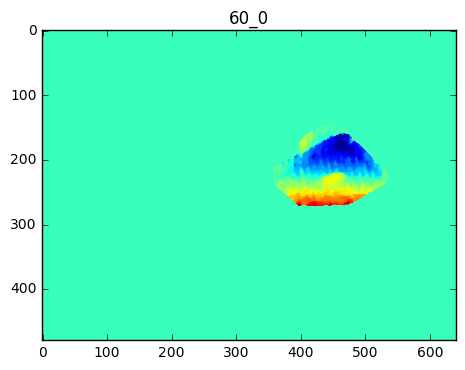

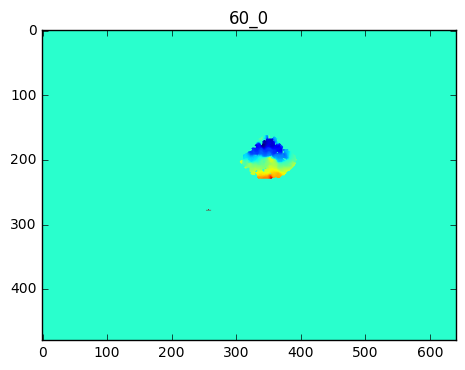

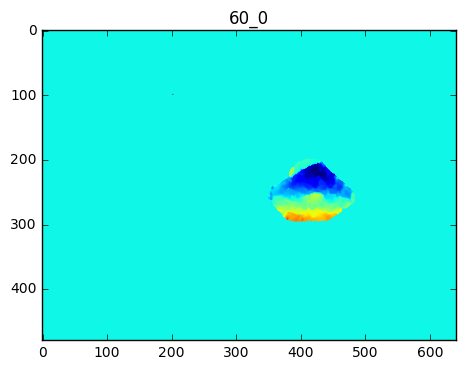

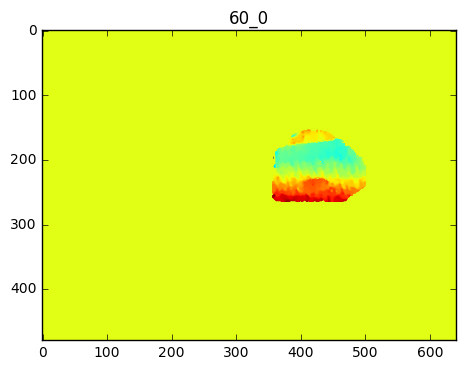

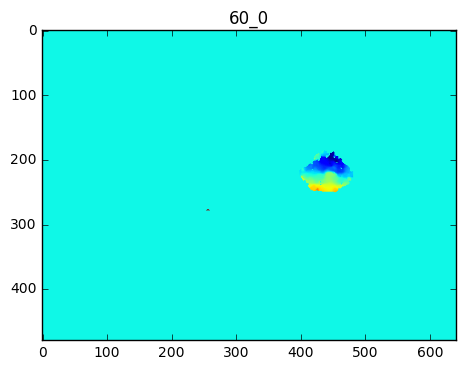

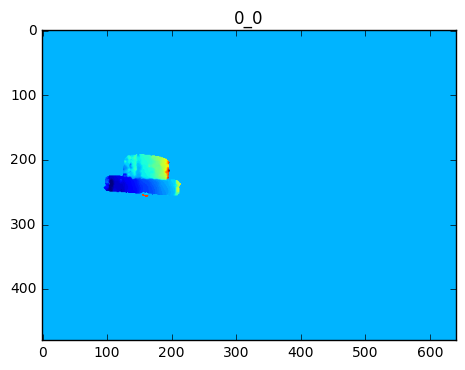

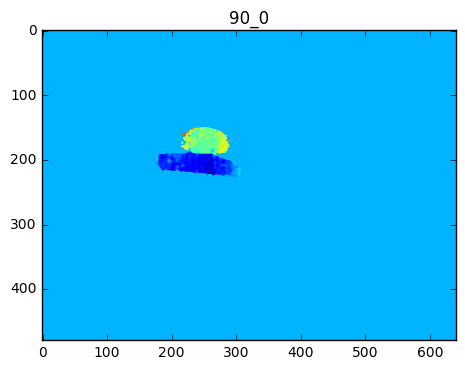

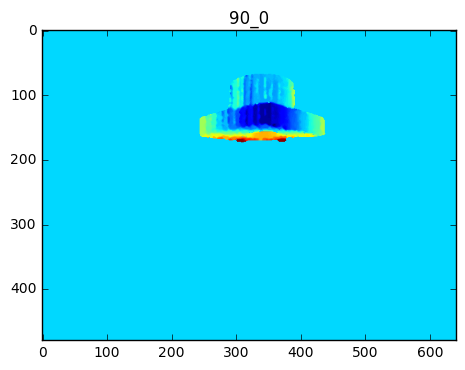

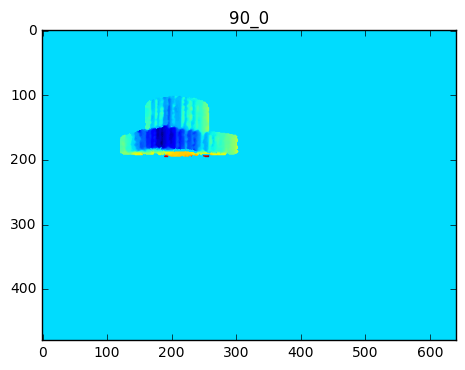

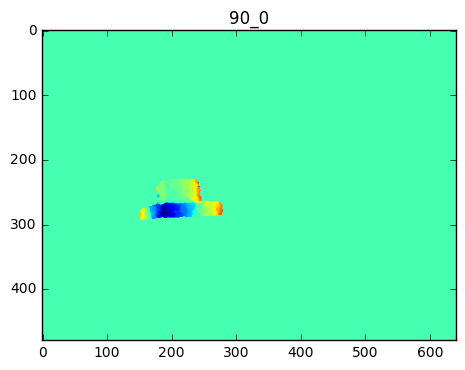

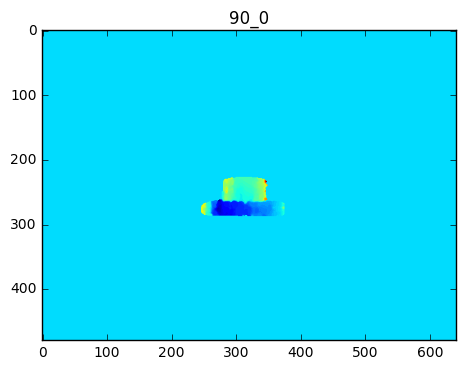

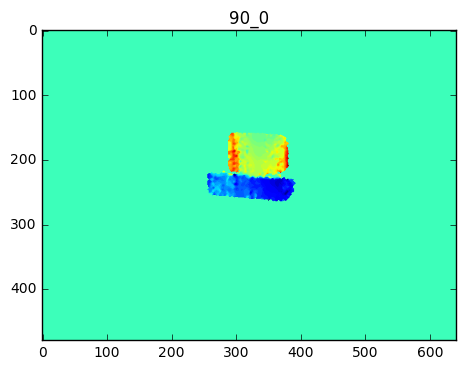

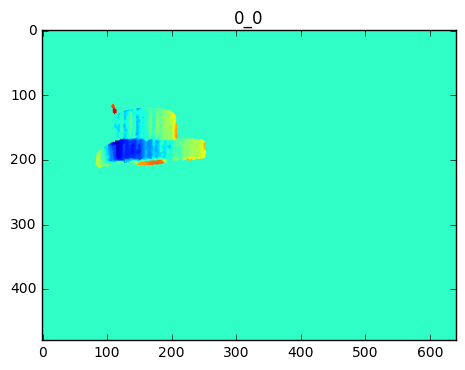

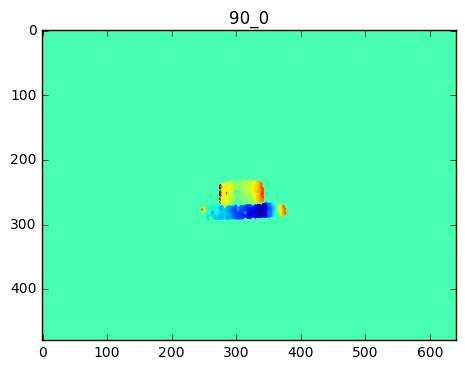

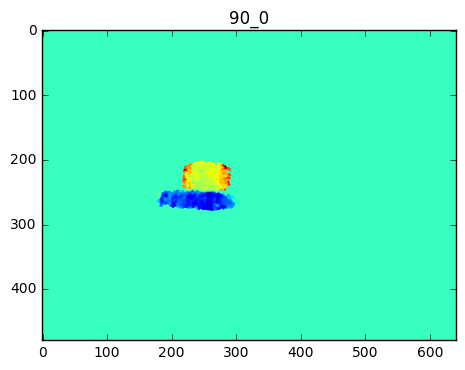

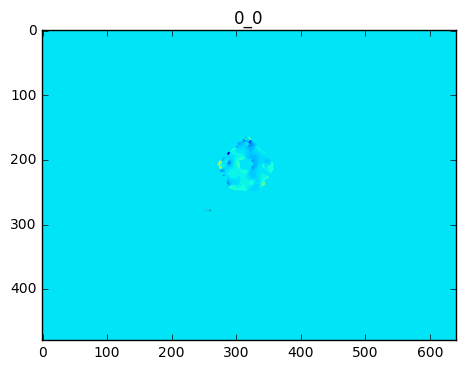

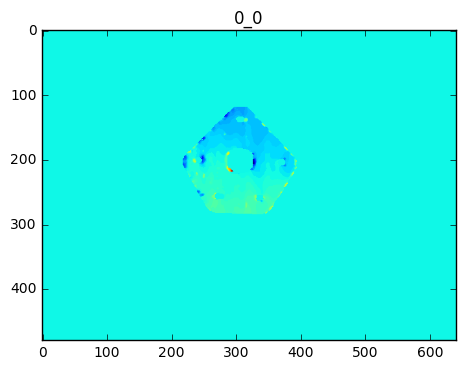

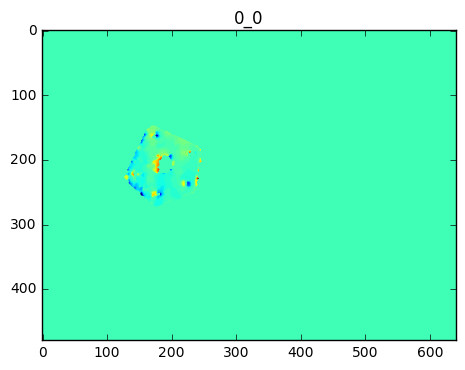

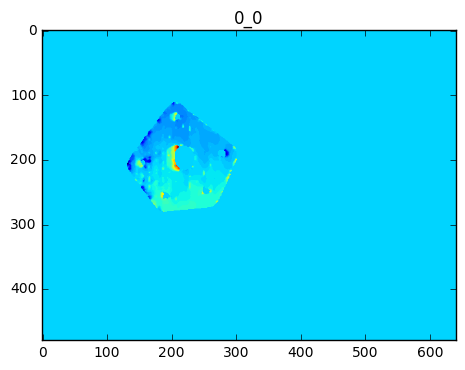

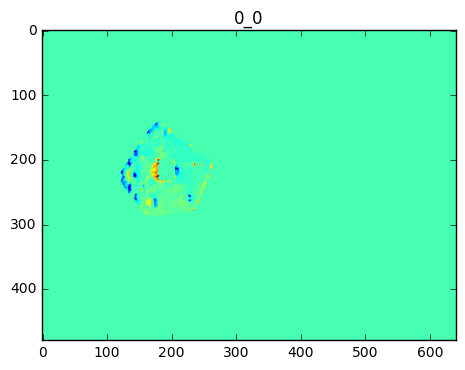

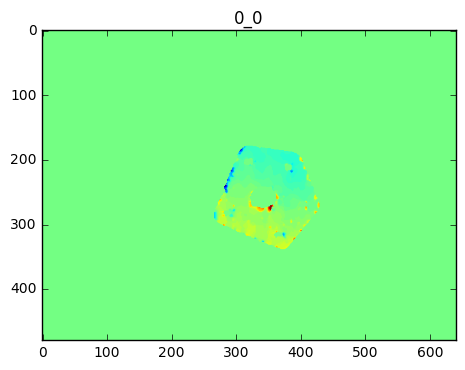

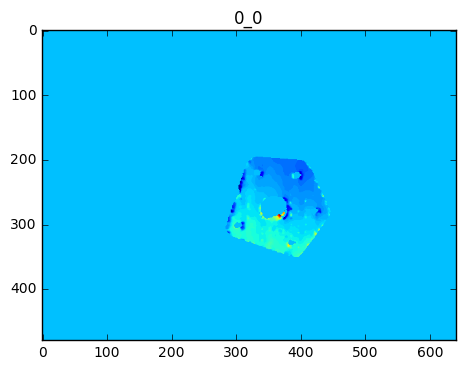

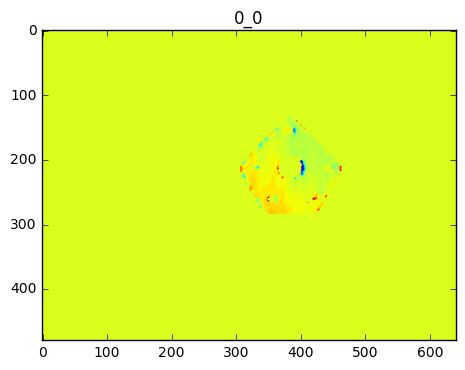

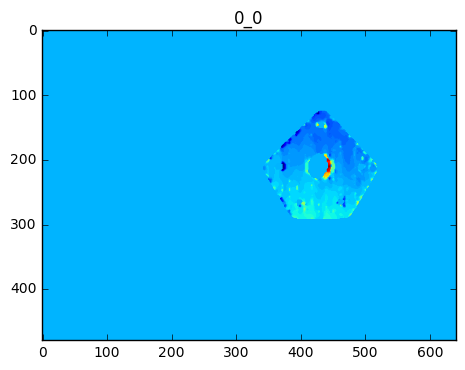

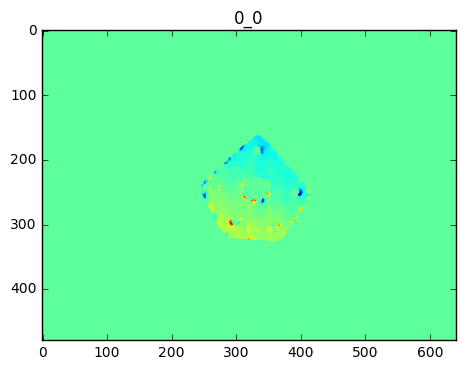

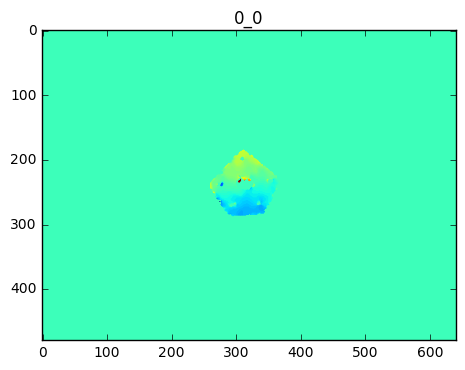

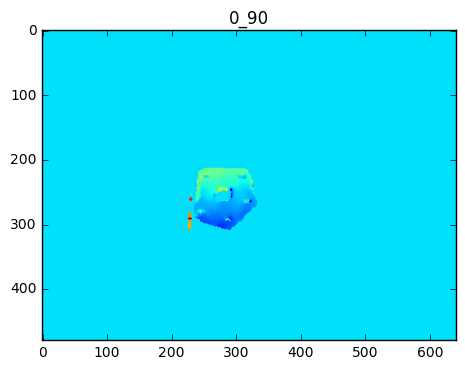

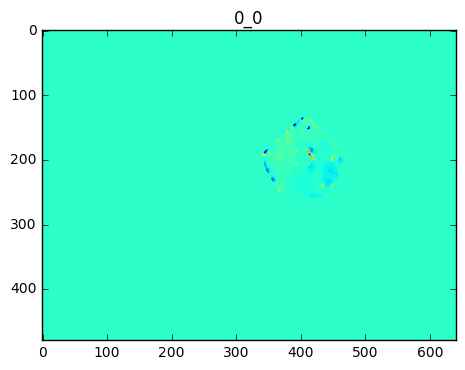

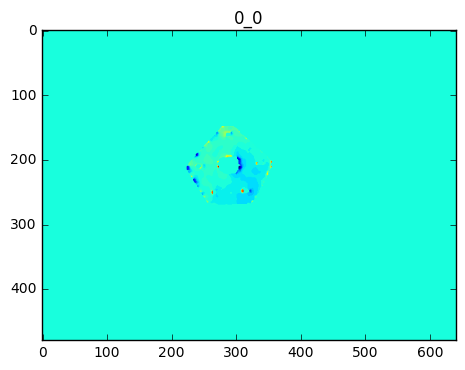

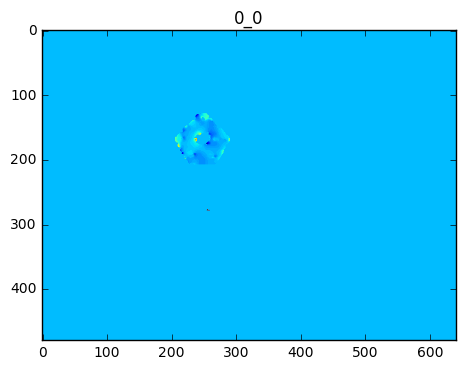

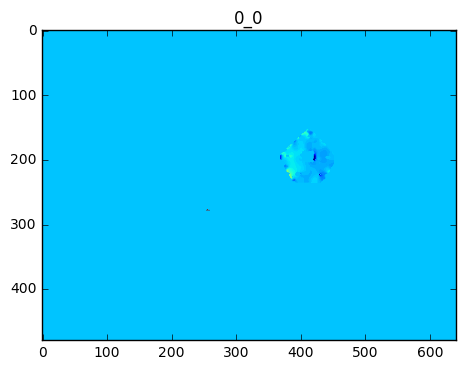

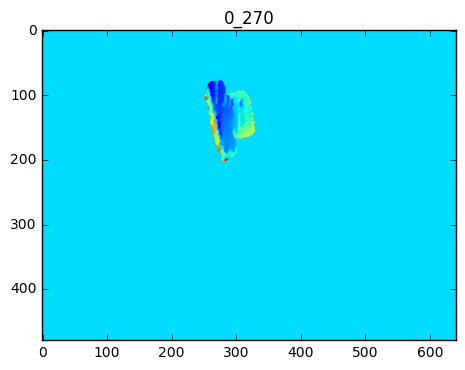

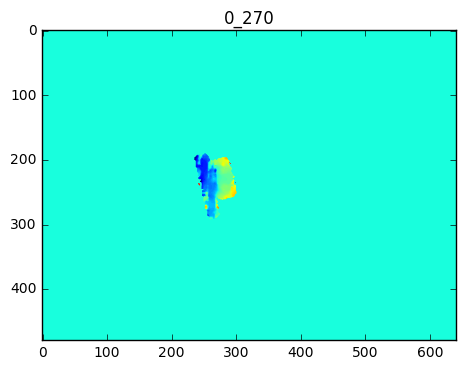

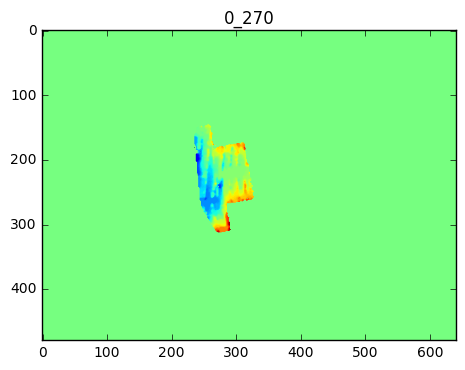

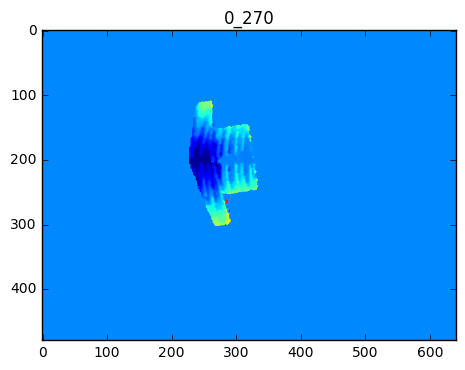

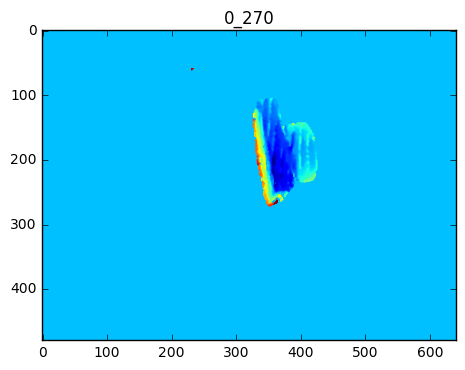

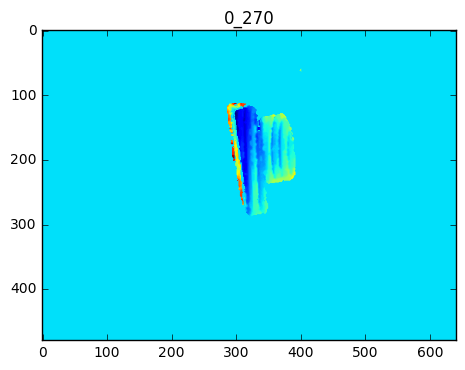

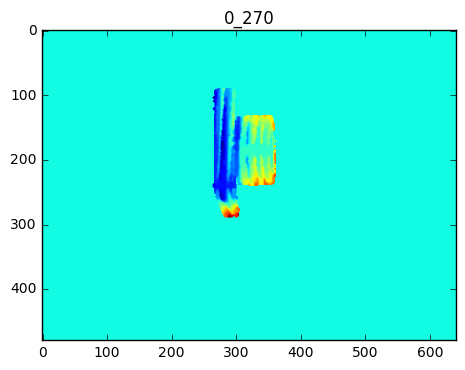

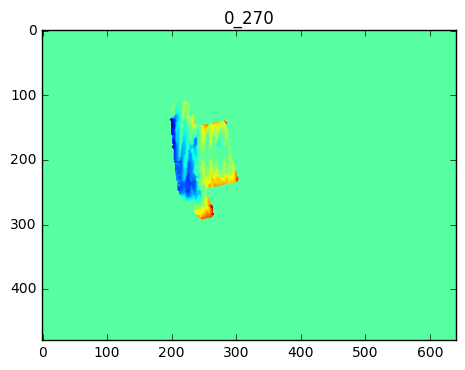

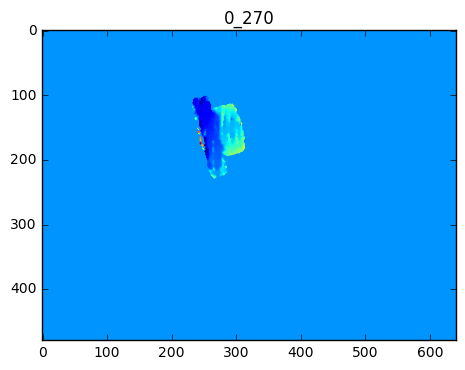

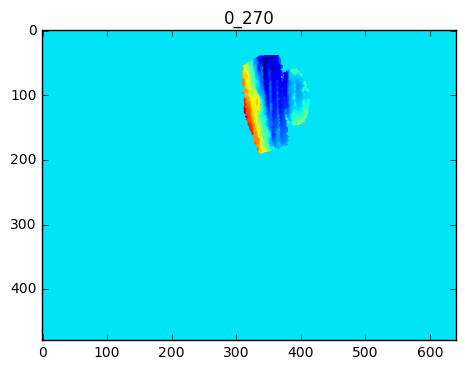

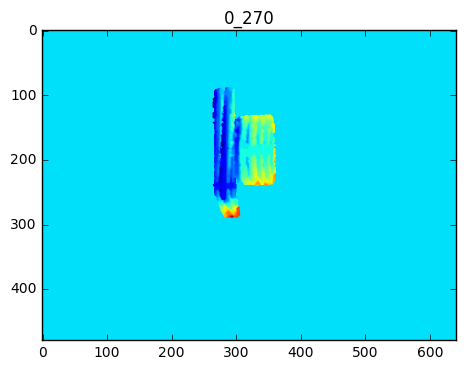

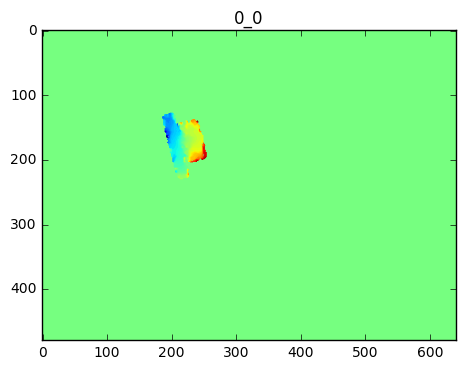

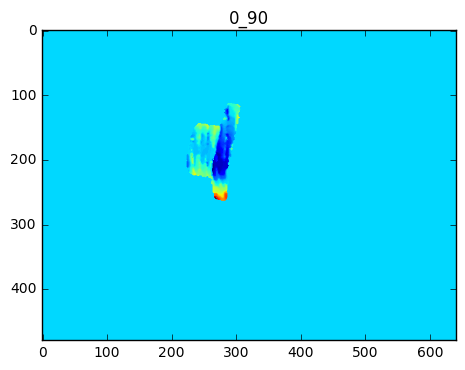

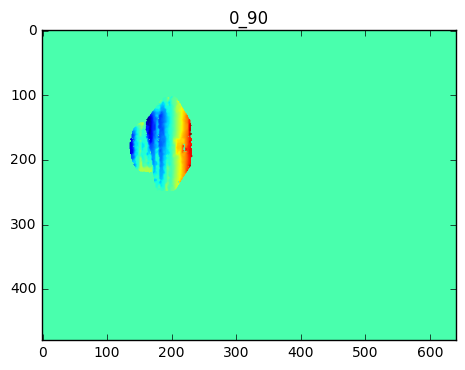

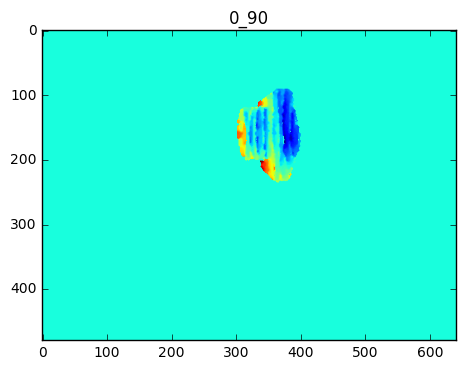

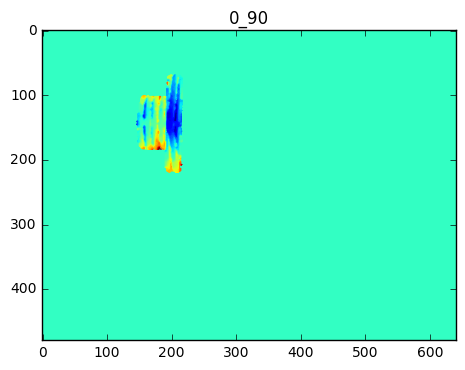

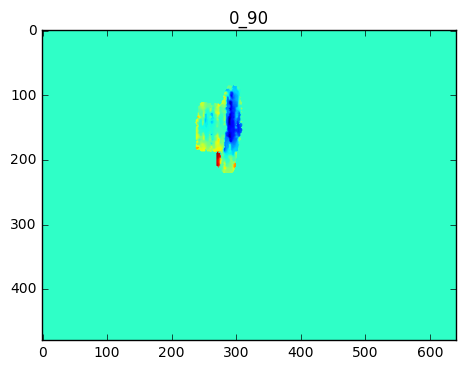

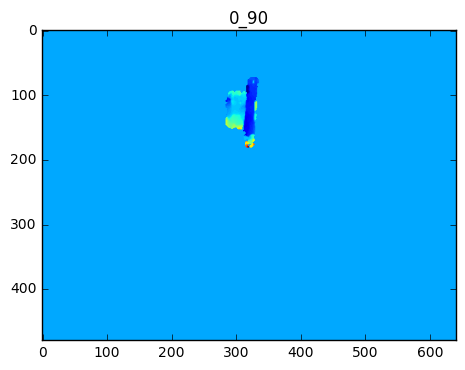

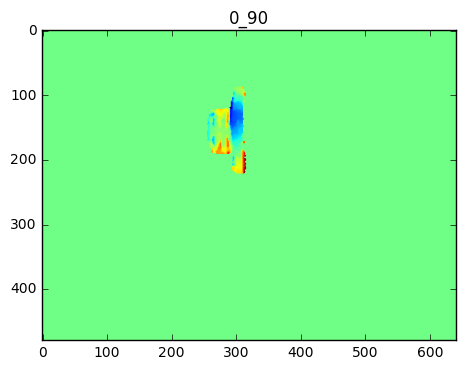

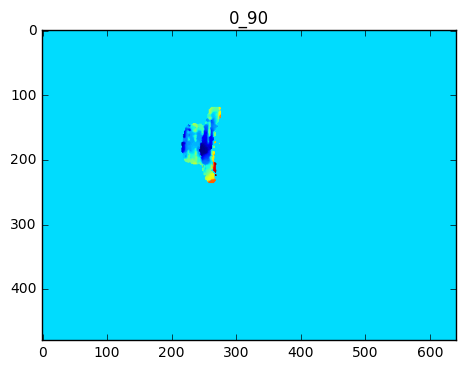

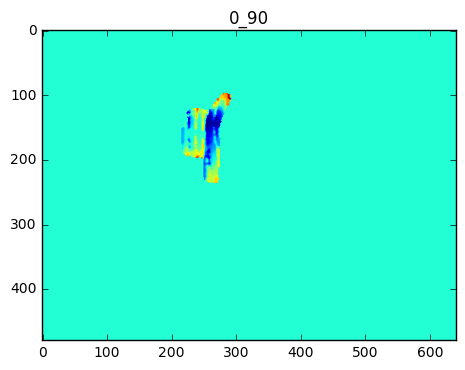

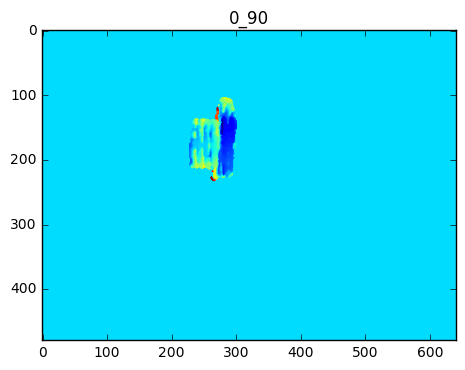

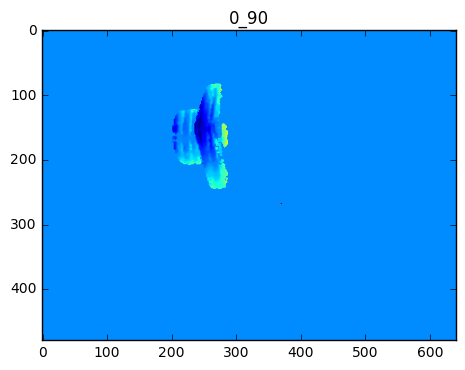

In [52]:
#test_model="./model/model_4class_7.pth"
test_model = all_best_model
dirname = './cropmap'
te,fd = visual_best_model(test_model,dirname)

In [73]:
dname='./cropmap'
model_dir = './model'
#modelname=glob.glob(model_dir+r'/model_4class_*.pth')
modelname=glob.glob(model_dir+r'/model_best_*.pth')
modelname = sorted(modelname)
bestacc=0
best_model=None
for model in modelname:
    acc,modeltemp=test_model(model,dname)
    if acc>=bestacc:
        best_model = modeltemp
        bestacc=acc
print('Best_Acc: {:.4f}'.format(bestacc))
print best_model

./model/model_best_1.pth`s Acc: 0.8800
./model/model_best_2.pth`s Acc: 0.7867
./model/model_best_3.pth`s Acc: 0.7600
./model/model_best_4.pth`s Acc: 0.7733
./model/model_best_5.pth`s Acc: 0.7733
./model/model_best_6.pth`s Acc: 0.7467
./model/model_best_7.pth`s Acc: 0.8133
./model/model_best_8.pth`s Acc: 0.8533
./model/model_best_9.pth`s Acc: 0.7867
Best_Acc: 0.8800
./model/model_best_1.pth
